In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data

In [10]:
df = pd.read_csv("/Users/danielmartins/Projects/Stanford ISLP/Data/5.Py.1.csv")
df

,X1,X2,y
0,1.297720,0.805921,0.298968
1,1.267323,0.799034,0.318134
2,1.236882,0.792169,0.337201
3,1.206317,0.785296,0.356121
4,1.175553,0.778385,0.374842
...,...,...,...
995,-0.771835,0.809153,0.202607
996,-0.770044,0.888314,0.212606
997,-0.768427,0.967673,0.222502
998,-0.766932,1.047105,0.232284


In [11]:
y = df['y']    # output variable, the median value of owner-occupied homes in $1000s
X = df[['X1', 'X2']]  # input variables
X = sm.add_constant(X)  # add intercept term
regressor_OLS = sm.OLS(y, X)  # We create a model object from statsmodels ordinary least squares regression
fitted = regressor_OLS.fit() # We fit the model to the data
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     66.14
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.06e-27
Time:                        17:24:04   Log-Likelihood:                -810.66
No. Observations:                1000   AIC:                             1627.
Df Residuals:                     997   BIC:                             1642.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2658      0.020     13.372      0.0

<Axes: >

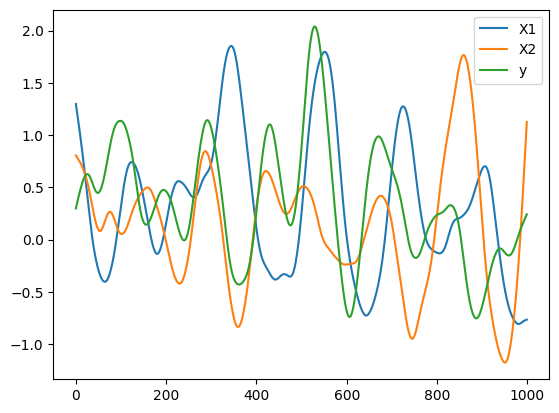

In [12]:
df.plot()

In [19]:
df.columns

Index(['X1', 'X2', 'y'], dtype='object')

In [28]:
def alpha_func(df, i):
   cov_ = np.cov(df[['X1','y']].loc[i], rowvar=False)
   return df[['X1',  'X2', 'y']].loc[i].std(ddof=1) / np.sqrt(len(i))

def boot_SE(func,
            df,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or df.shape[0]
    for _ in range(B):
        i = rng.choice(df.index,
                         n,
                         replace=True)
        value = func(df, i)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

alpha_SE = boot_SE(alpha_func,
                   df,
                   B=1000,
                   seed=0)
alpha_SE

X1    0.000405
X2    0.000462
y     0.000417
dtype: float64

In [ ]:
new_rows = np.r_[slice(100,200), slice(400,500), slice(100, 200), slice(900,1000), slice(300,400), slice(0, 100), slice(0,100), slice(800,900), slice(200,300), slice(700, 800)]

new_df = df.iloc[new_rows]

In [ ]:
new_df

,X1,X2,y
100,0.327028,0.054913,1.135742
101,0.358675,0.053752,1.134353
102,0.389793,0.053699,1.132062
103,0.420223,0.054714,1.128780
104,0.449808,0.056759,1.124419
...,...,...,...
795,-0.114930,0.045319,0.216452
796,-0.117514,0.082170,0.221325
797,-0.119879,0.119577,0.225746
798,-0.122021,0.157421,0.229727
